In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


c:\Users\17813\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Download Data & Basic Setup

In [2]:
# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/global-weather-repository")
print("Path to dataset files:", path)

100%|██████████| 5.29M/5.29M [00:00<00:00, 6.43MB/s]

Extracting files...


Path to dataset files: C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\573


In [3]:
data_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536"
print(os.listdir(data_path))  # List all files in the directory
file_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536\GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)

['GlobalWeatherRepository.csv', 'state.db']


# Data Cleaning & Preprocessing
#### Handle missing values, outliers, and normalize data.


In [4]:
# display basic data information and column names
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60218 entries, 0 to 60217
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       60218 non-null  object 
 1   location_name                 60218 non-null  object 
 2   latitude                      60218 non-null  float64
 3   longitude                     60218 non-null  float64
 4   timezone                      60218 non-null  object 
 5   last_updated_epoch            60218 non-null  int64  
 6   last_updated                  60218 non-null  object 
 7   temperature_celsius           60218 non-null  float64
 8   temperature_fahrenheit        60218 non-null  float64
 9   condition_text                60218 non-null  object 
 10  wind_mph                      60218 non-null  float64
 11  wind_kph                      60218 non-null  float64
 12  wind_degree                   60218 non-null  int64  
 13  w

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [5]:
# remove duplicates inplace
check_duplicates = df.duplicated().sum()
print(f'Total duplicate rows: {check_duplicates}')

Total duplicate rows: 0


In [6]:
# check missing values per column 
print(f'number of missing values per column: {df.isnull().sum()}')
# check missing values for each row
print(f'number of missing values for each row: {df[df.isnull().any(axis=1)]}')
# number of numeric columns:
print(f'Number of numerical columns: {df.select_dtypes(include="number").shape[1]}')
# number of categorical columns
print(f'Number of categorical columns: {df.select_dtypes(include="object").shape[1]}')


number of missing values per column: country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality

## key observations:
1. Total number of features (columns): 41
2. Total number of rows: 60218 
3. Number of numerical columns: 31
4. Number of categorical columns: 10
5. There is no column or row that contains missing values
6. There are no duplicates present in the given Dataset

## Isolation Forest to detect outliers
(Since this dataset contains 41 features, indicating that it is multivariate relationship, we cannot use normal IQR method to detect outliers. And Isolation Forest can be suitable.)

c:\Users\17813\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


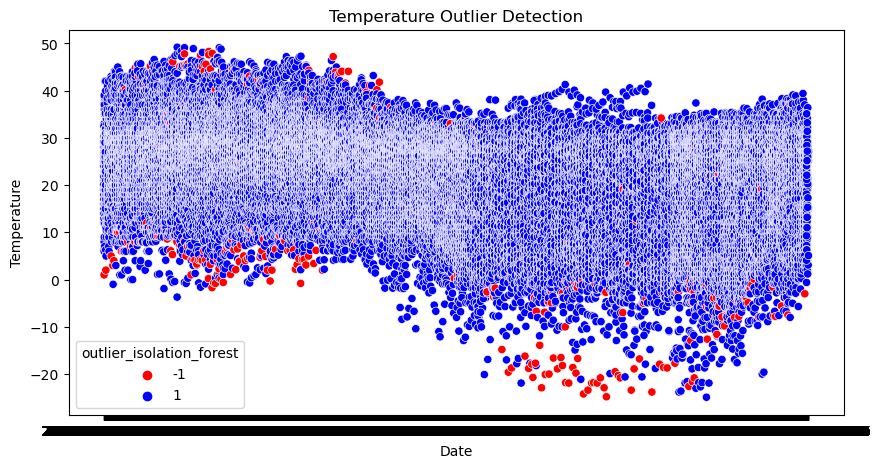

         country   location_name  latitude  longitude            timezone  \
35         Chile        Santiago  -33.4500   -70.6700    America/Santiago   
78     Indonesia         Jakarta   -6.2100   106.8500        Asia/Jakarta   
230        Chile        Santiago  -33.4500   -70.6700    America/Santiago   
231        China         Beijing   39.9300   116.3900       Asia/Shanghai   
273    Indonesia         Jakarta   -6.2100   106.8500        Asia/Jakarta   
...          ...             ...       ...        ...                 ...   
58495     Canada          Ottawa   45.4167   -75.7000     America/Toronto   
58692       Chad       N'djamena   12.1131    15.0492       Africa/Douala   
58694      China         Beijing   39.9289   116.3883       Asia/Shanghai   
59709    Iceland  Vestmannaeyjar   63.3650   -20.2075  Atlantic/Reykjavik   
59860     Canada          Ottawa   45.4167   -75.7000     America/Toronto   

       last_updated_epoch      last_updated  temperature_celsius  \
35     

In [7]:
# Isolation Forest:

#only use numeric features:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
features = [col for col in numeric_features if col != 'temperature']  # Exclude 'temperature' from features
X = df[['temperature_celsius'] + features] 

# Create and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01)  
outliers = iso_forest.fit_predict(X)

# Mark the outliers (-1 indicates outliers, 1 indicates inliers)
df['outlier_isolation_forest'] = outliers

# Visualize outliers
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='last_updated', y='temperature_celsius', hue='outlier_isolation_forest', palette={1:'blue', -1:'red'})
plt.title('Temperature Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

# Print the rows identified as outliers
outliers_df = df[df['outlier_isolation_forest'] == -1]
print(outliers_df)

In [8]:
cleaned_df = df[df['outlier_isolation_forest'] != -1]
cleaned_df.drop(columns = 'outlier_isolation_forest', inplace=True)
print(f'data shape before cleaning outliers: {df.shape}')
print(f'data shape after cleaning outliers: {cleaned_df.shape}')

data shape before cleaning outliers: (60218, 42)
data shape after cleaning outliers: (59615, 41)


C:\Users\17813\AppData\Local\Temp\ipykernel_21800\2754756356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns = 'outlier_isolation_forest', inplace=True)


# Exploratory Data Analysis (EDA)
#### Perform basic EDA to uncover the trends, correlations, and patterns.
#### Generate visualizations for temperature and precipitation.


#### Country related EDA

In [9]:
print(f'Number of unique countries: {df["country"].nunique()}')
print(f'Number of unique locations: {df["location_name"].nunique()}')

Number of unique countries: 210
Number of unique locations: 248


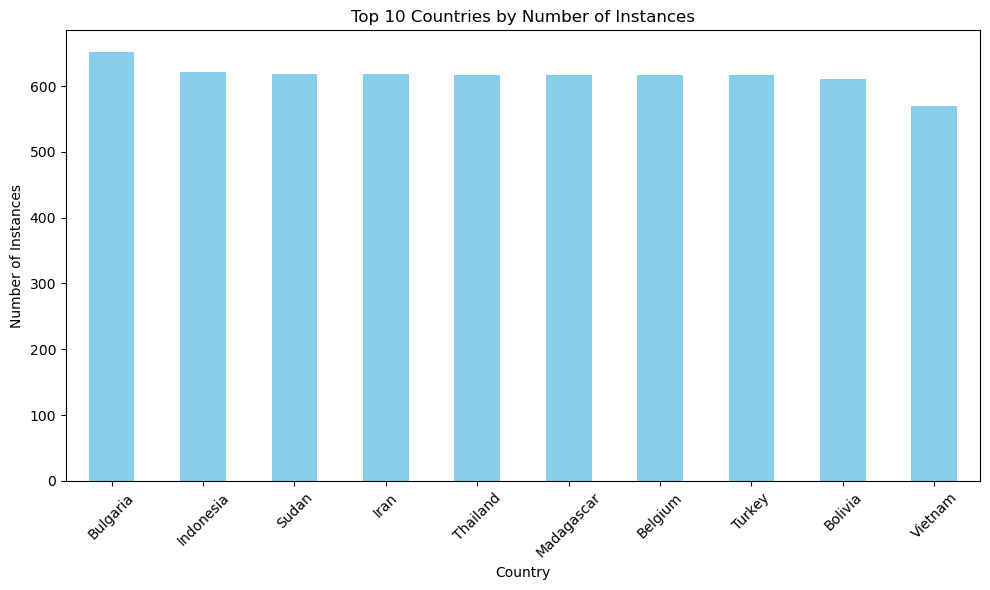

In [10]:
# Get the top 10 countries by count
top_n = 10
country_counts = df['country'].value_counts().head(top_n)

# Plot the top N countries
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Countries by Number of Instances')
plt.xlabel('Country')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Latitude and Temperature related EDA

                                  min      max    range
country                                                
USA United States of America   7.5000  39.5300  32.0300
Brazil                       -23.5300  -2.0800  21.4500
Vietnam                       10.7500  21.1333  10.3833
Indonesia                     -8.1826  -0.1400   8.0426
Bolivia                      -19.0431 -11.1800   7.8631
...                               ...      ...      ...
Komoren                      -12.3500 -12.3500   0.0000
Jordan                        31.9500  31.9500   0.0000
Jemen                         15.3500  15.3500   0.0000
Italy                         41.9000  41.9000   0.0000
火鸡                            38.8500  38.8500   0.0000

[210 rows x 3 columns]


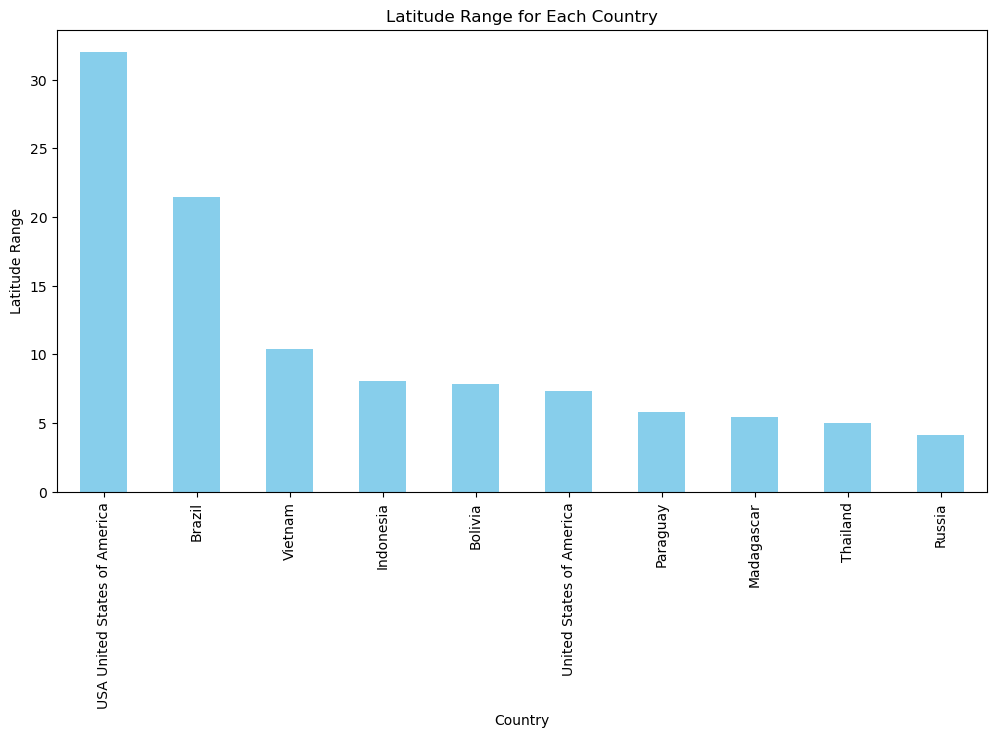

In [11]:
# Group the data by 'country' and calculate the min and max latitude for each country
latitude_range = df.groupby('country')['latitude'].agg(['min', 'max'])

# Add a new column for the range (max - min)
latitude_range['range'] = latitude_range['max'] - latitude_range['min']

# Sort countries by latitude range in descending order
latitude_range_sorted = latitude_range.sort_values(by='range', ascending=False)

# Display the sorted results
print(latitude_range_sorted)

# Plot the latitude range for each country
plt.figure(figsize=(12, 6))
latitude_range_sorted['range'].head(10).plot(kind='bar', color='skyblue')
plt.title('Latitude Range for Each Country')
plt.xlabel('Country')
plt.ylabel('Latitude Range')
plt.xticks(rotation=90)
plt.show()



Latitude Summary Stats for United States of America:
count    305.000000
mean      47.977756
std        0.532419
min       40.710000
25%       48.079200
50%       48.079200
75%       48.080000
max       48.080000
Name: latitude, dtype: float64

Temperature (Celsius) Summary Stats for United States of America:
count    305.000000
mean       8.060000
std        3.796307
min       -2.800000
25%        5.400000
50%        8.400000
75%       11.000000
max       26.100000
Name: temperature_celsius, dtype: float64


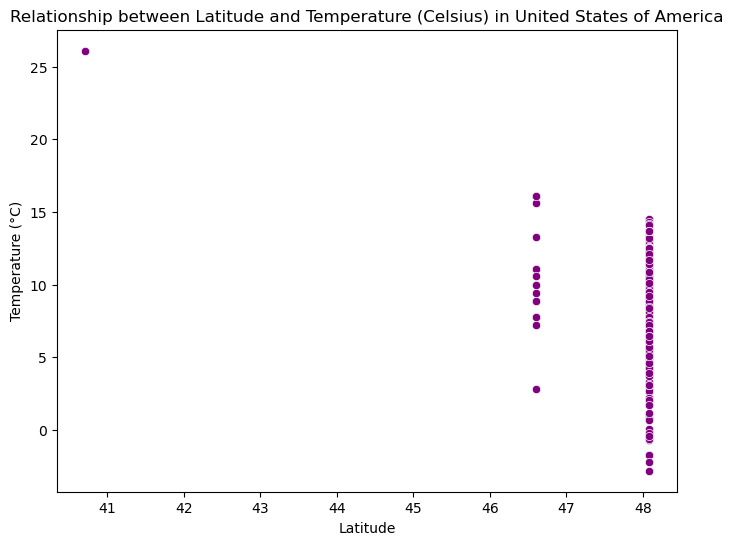

In [12]:
# Filter the dataframe for a specific country
country_name = "United States of America"
country_data = df[df['country'] == country_name]

# Summary statistics for 'latitude' and 'temperature_celsius' in the specified country
latitude_stats = country_data['latitude'].describe()
temperature_stats = country_data['temperature_celsius'].describe()

print(f"\nLatitude Summary Stats for {country_name}:")
print(latitude_stats)

print(f"\nTemperature (Celsius) Summary Stats for {country_name}:")
print(temperature_stats)

# Scatter plot to visualize the relationship between latitude and temperature for the specific country
plt.figure(figsize=(8, 6))
sns.scatterplot(x=country_data['latitude'], y=country_data['temperature_celsius'], color='purple')
plt.title(f'Relationship between Latitude and Temperature (Celsius) in {country_name}')
plt.xlabel('Latitude')
plt.ylabel('Temperature (°C)')
plt.show()


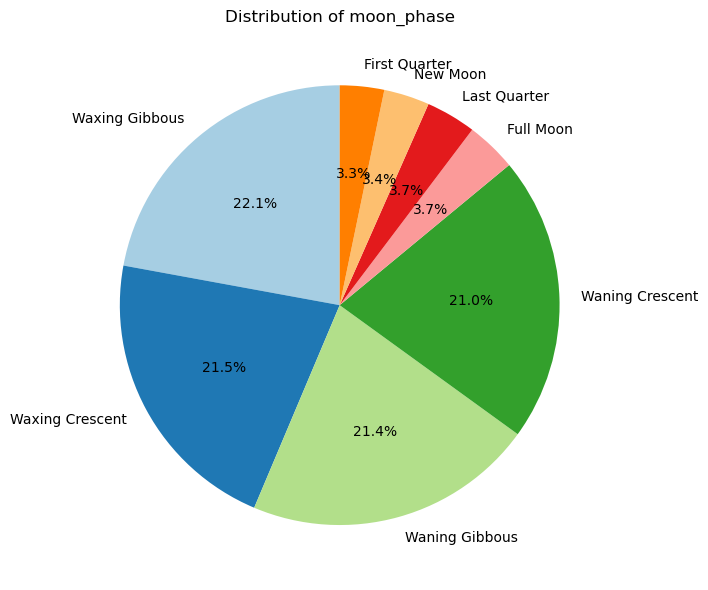

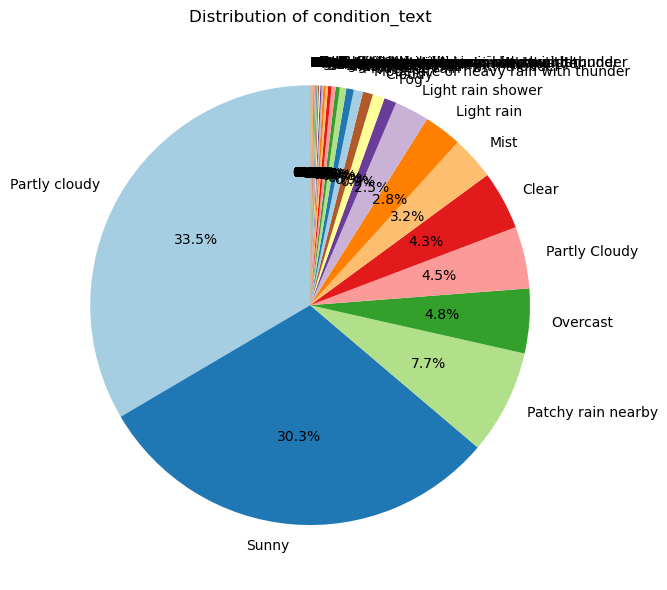

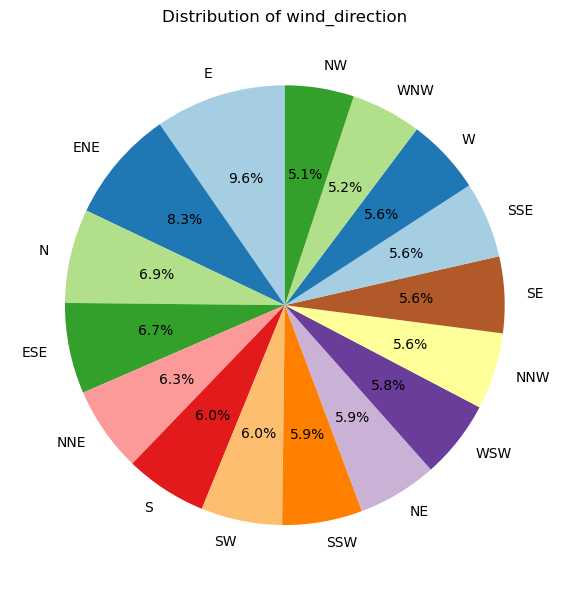

In [13]:
# Specify categorical columns you want to analyze
categorical_columns = ['moon_phase', 'condition_text', 'wind_direction']

# Loop through each categorical column and plot a pie chart
for column in categorical_columns:
    plt.figure(figsize=(8, 6))  # Create a new figure for each pie chart
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f'Distribution of {column}')
    plt.ylabel('')  # Remove the 'ylabel' to avoid it overlapping the pie chart
    plt.tight_layout()  # Adjust layout to avoid overlap

# Show all pie charts
plt.show()



### key observations
1. There are 210 unique countries
2. There are 248 unique locations
3. Top 10 countries by count are: Bulgaria, Indonesia, Sudan, Iran, Thaliand, Madagascar, Belgium, Turkey, Bolivia, Vietnam
4. USA has the highest latitude difference among all the available countries, and it contains 308 instances. But it does not show an obvious correlation between temperature and latitude

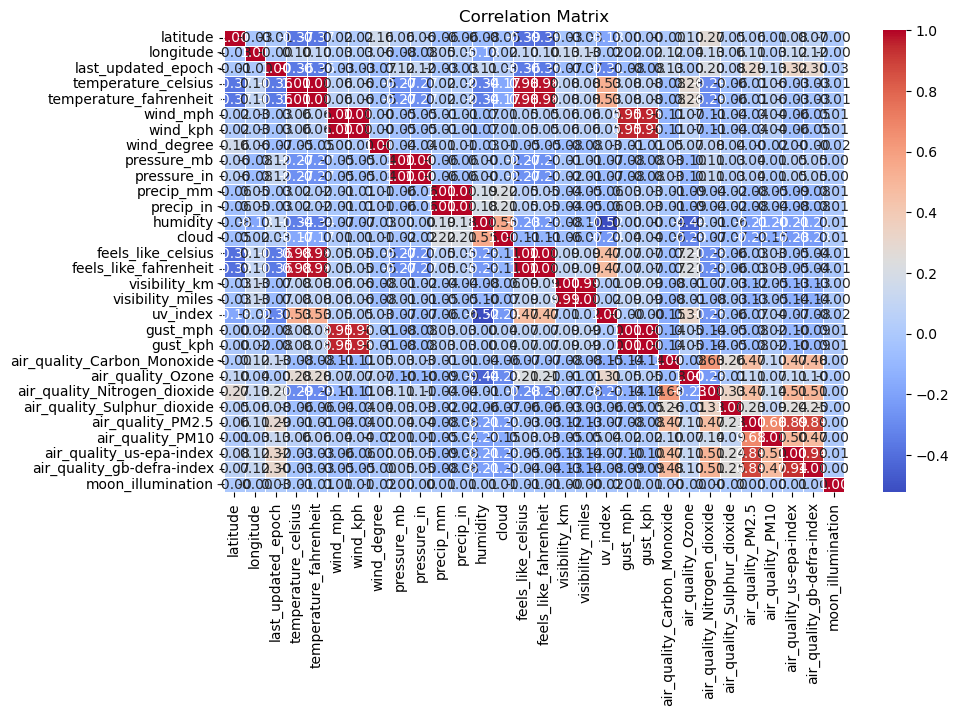

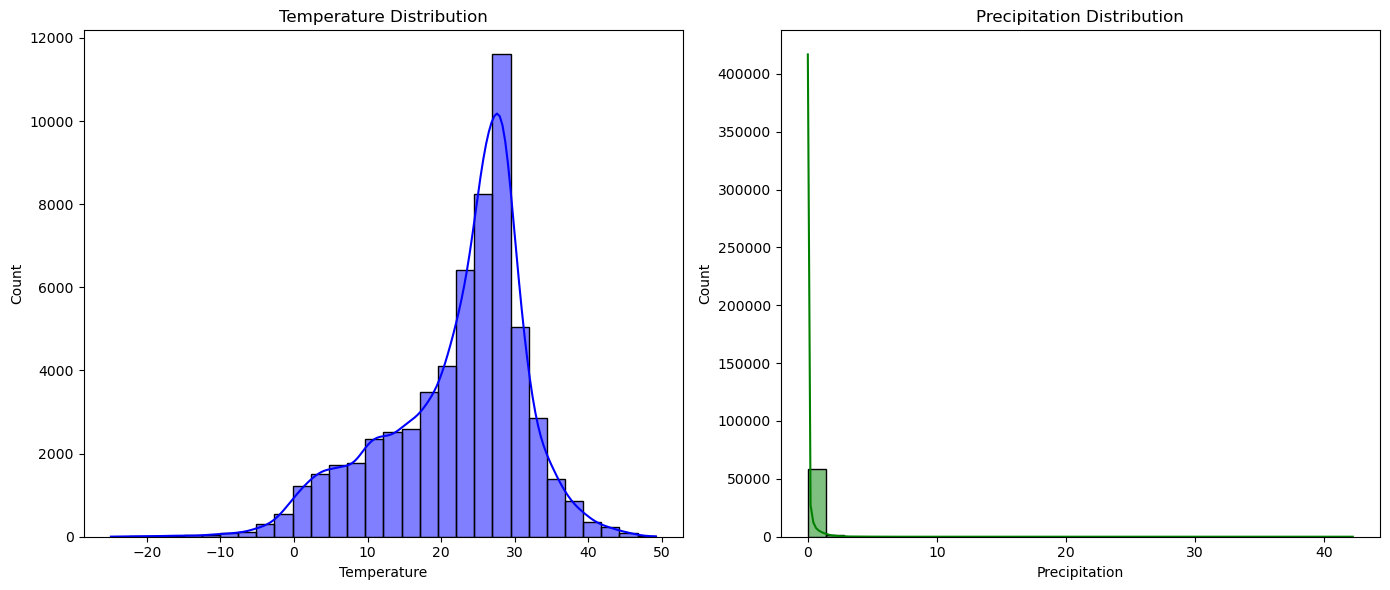

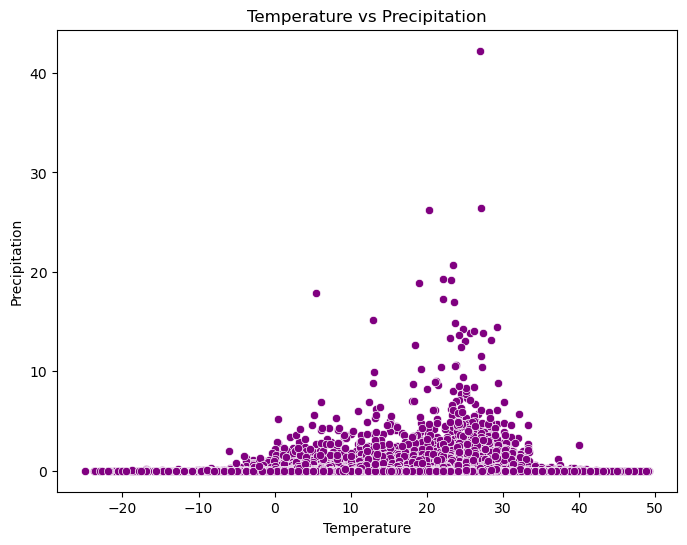

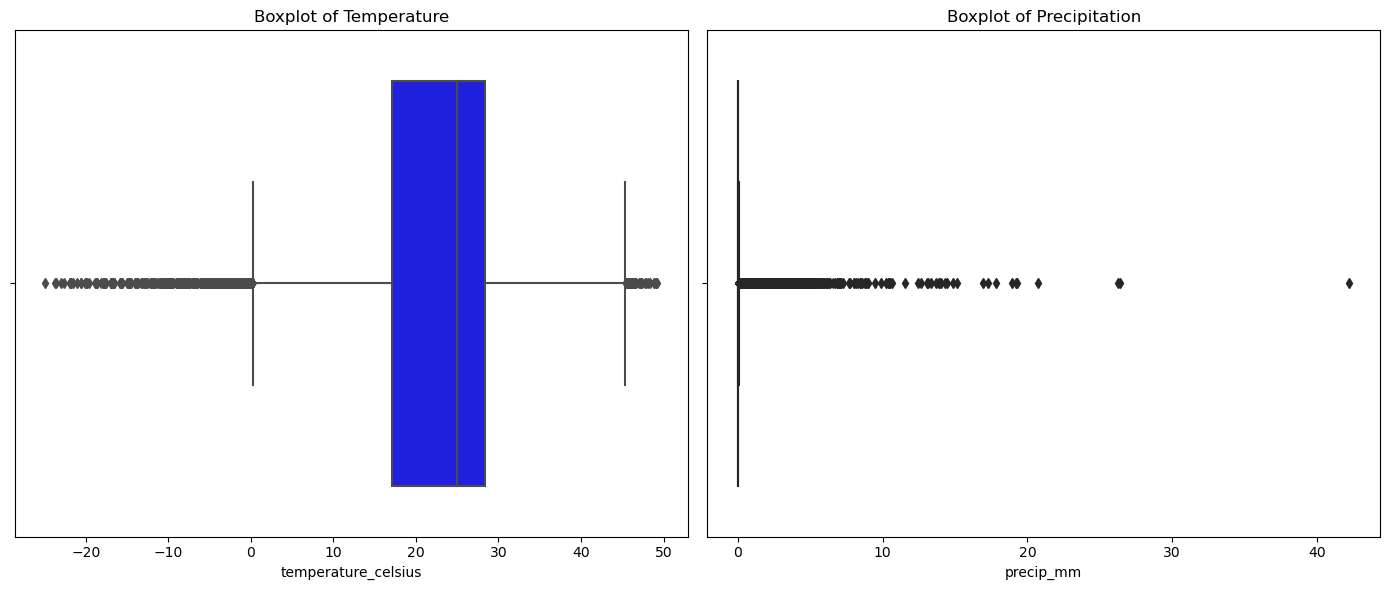

C:\Users\17813\AppData\Local\Temp\ipykernel_21800\3679398885.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['last_updated'] = pd.to_datetime(cleaned_df['last_updated'])  # Ensure 'date' column is in datetime format


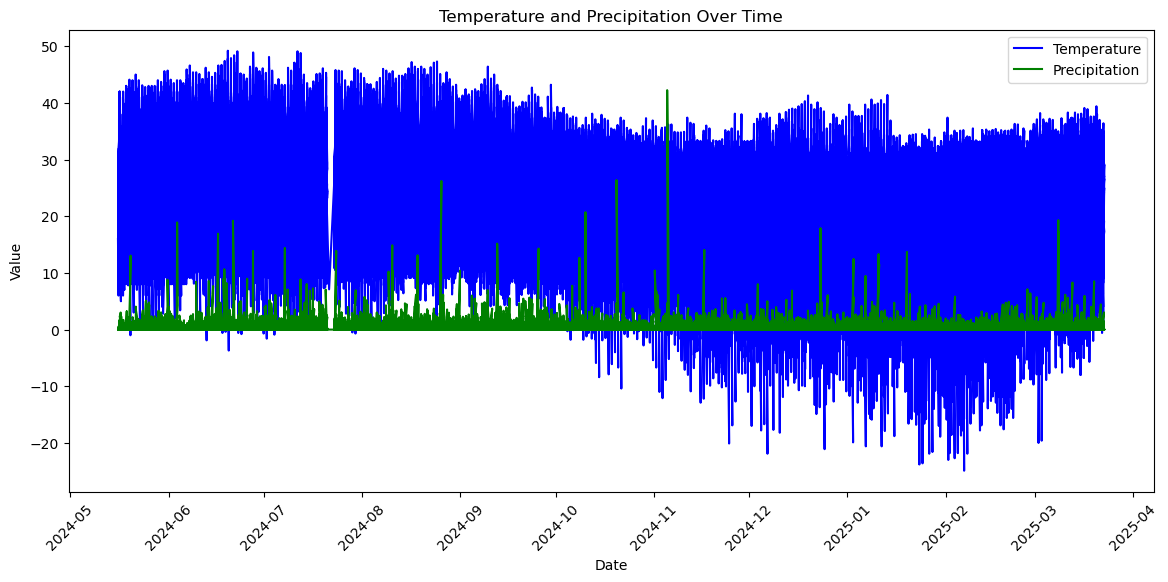

In [14]:
# correlation matrix heatmap:
correlation_matrix = cleaned_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Distribution of Temperature and Precipitation
plt.figure(figsize=(14, 6))

# Temperature Distribution
plt.subplot(1, 2, 1)
sns.histplot(cleaned_df['temperature_celsius'], kde=True, color='blue', bins=30)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')

# Precipitation Distribution
plt.subplot(1, 2, 2)
sns.histplot(cleaned_df['precip_mm'], kde=True, color='green', bins=30)
plt.title('Precipitation Distribution')
plt.xlabel('Precipitation')

plt.tight_layout()
plt.show()

# Scatter Plot: Temperature vs Precipitation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature_celsius', y='precip_mm', data=cleaned_df, color='purple')
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.show()

# 6. Boxplot to check for outliers (Temperature and Precipitation)
plt.figure(figsize=(14, 6))

# Boxplot for Temperature
plt.subplot(1, 2, 1)
sns.boxplot(x=cleaned_df['temperature_celsius'], color='blue')
plt.title('Boxplot of Temperature')

# Boxplot for Precipitation
plt.subplot(1, 2, 2)
sns.boxplot(x=cleaned_df['precip_mm'], color='green')
plt.title('Boxplot of Precipitation')

plt.tight_layout()
plt.show()

# Time Series Plot (if data has a time component, e.g., 'date')
if 'last_updated' in cleaned_df.columns:
    cleaned_df['last_updated'] = pd.to_datetime(cleaned_df['last_updated'])  # Ensure 'date' column is in datetime format
    plt.figure(figsize=(14, 6))
    plt.plot(cleaned_df['last_updated'], cleaned_df['temperature_celsius'], label='Temperature', color='blue')
    plt.plot(cleaned_df['last_updated'], cleaned_df['precip_mm'], label='Precipitation', color='green')
    plt.title('Temperature and Precipitation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Model Building
#### Build a basic forecasting model and evaluate its performance using different metrics.
#### Use lastupdated feature for the time series analysis

c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ARIMA MAE: 3.1984317355185574
ARIMA RMSE: 3.8377578822323204


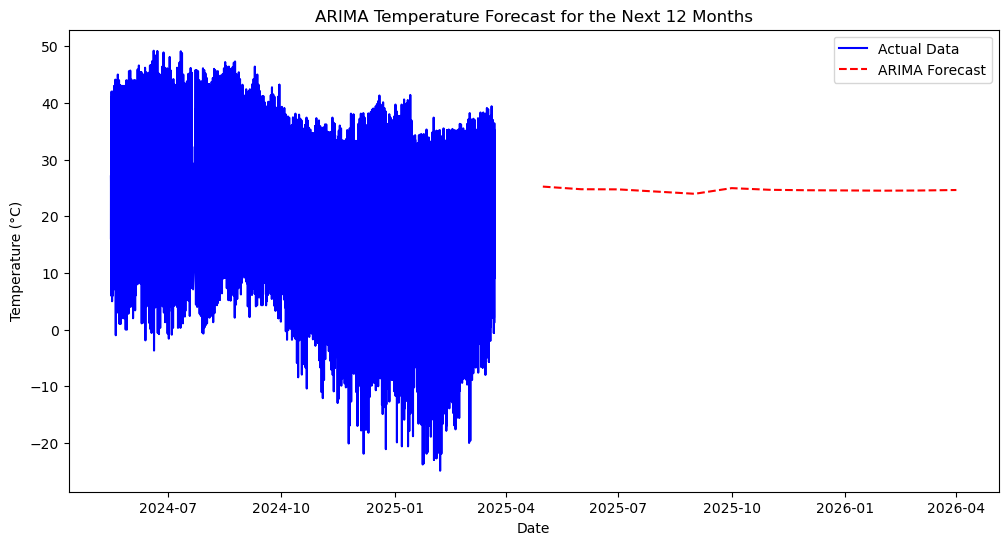

In [20]:
# Sort by datetime and set index
cleaned_df = cleaned_df.sort_values(by='last_updated')
cleaned_df.set_index('last_updated', inplace=True)

# Extract time-related features
cleaned_df['month'] = cleaned_df.index.month
cleaned_df['day_of_week'] = cleaned_df.index.dayofweek  # 0 = Monday, 6 = Sunday
cleaned_df['hour'] = cleaned_df.index.hour

# Define target variable
target = 'temperature_celsius'

# Split data into train and test sets
train, test = train_test_split(cleaned_df, test_size=0.2, random_state=42)
train = train.sort_index()
test = test.sort_index()

# Build and fit ARIMA model
model = ARIMA(train[target], order=(5, 1, 0))
model_fit = model.fit()

# Generate forecast for the next 12 months
forecast = model_fit.forecast(steps=12)

# Generate forecast index for the next 12 months
forecast_index = pd.date_range(start=cleaned_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Assign forecast index
forecast.index = forecast_index

# Retrieve actual last 12 months for evaluation
available_length = min(len(cleaned_df), 12)
actual = cleaned_df[target].iloc[-available_length:]

# Align forecasted and actual values
forecast_eval = forecast[:available_length]

# Calculate evaluation metrics
mae = mean_absolute_error(actual, forecast_eval)
rmse = np.sqrt(mean_squared_error(actual, forecast_eval))

# Print evaluation metrics
print(f"ARIMA MAE: {mae}")
print(f"ARIMA RMSE: {rmse}")

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df.index, cleaned_df[target], label="Actual Data", color='blue')
plt.plot(forecast.index, forecast, label="ARIMA Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("ARIMA Temperature Forecast for the Next 12 Months")
plt.legend()
plt.show()

In [21]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Extract time features (optional for ARIMA)
cleaned_df['month'] = cleaned_df.index.month
cleaned_df['day_of_week'] = cleaned_df.index.dayofweek
cleaned_df['hour'] = cleaned_df.index.hour

# Define target
target = 'temperature_celsius'

# Train/test split
train, test = train_test_split(cleaned_df, test_size=0.2, random_state=42)
train = train.sort_index()
test = test.sort_index()

# Grid search for best (p, d, q)
p = d = q = range(0, 4)  # You can increase the range if needed
pdq = [(5, 1, 0)]

results = []
best_aic = np.inf
best_order = None
best_model_fit = None

print("Starting grid search over ARIMA (p,d,q):\n")

for order in pdq:
    try:
        model = ARIMA(train[target], order=order)
        model_fit = model.fit()
        aic = model_fit.aic

        # Forecast and evaluate
        forecast = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test[target], forecast)
        rmse = np.sqrt(mean_squared_error(test[target], forecast))

        print(f"Order {order} -> AIC: {aic:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        
        results.append((order, aic, mae, rmse))
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model_fit = model_fit

    except Exception as e:
        print(f"Order {order} failed: {e}")
        continue

print("\nBest ARIMA order:", best_order)
print(f"Best AIC: {best_aic:.2f}")

# Forecast next 12 months using best model
forecast = best_model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=cleaned_df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast.index = forecast_index

# Evaluate against last 12 known values if available
available_length = min(len(cleaned_df), 12)
actual = cleaned_df[target].iloc[-available_length:]
forecast_eval = forecast[:available_length]

mae = mean_absolute_error(actual, forecast_eval)
rmse = np.sqrt(mean_squared_error(actual, forecast_eval))

print(f"\nFinal Forecast Evaluation on Last 12 Months:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Starting grid search over ARIMA (p,d,q):



c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Order (5, 1, 0) -> AIC: 344414.31, MAE: 7.19, RMSE: 9.78

Best ARIMA order: (5, 1, 0)
Best AIC: 344414.31

Final Forecast Evaluation on Last 12 Months:
MAE: 3.20
RMSE: 3.84


c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Facebook Prophet model

In [16]:
!pip install prophet

15:15:25 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing


Test MAE: 9.4476
Test RMSE: 10.9091
Test R2 Score: -0.0447


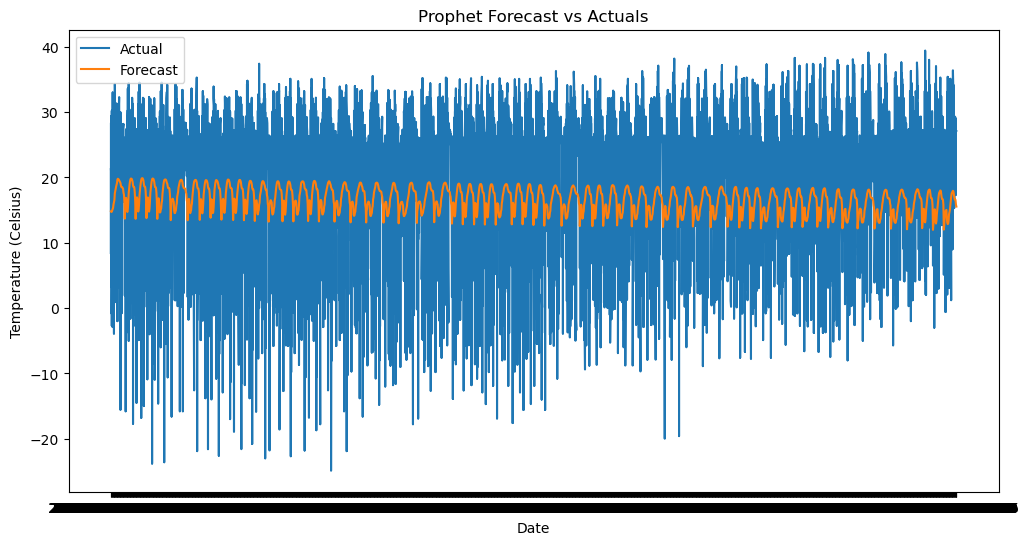

In [18]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare and sort
prophet_df = df.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
prophet_df = prophet_df.sort_values('ds')

# Train-test split
train_size = int(0.8 * len(prophet_df))
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Train Prophet
prophet_model = Prophet()
prophet_model.fit(train_df)

# Forecast on test dates
future = test_df[['ds']]
forecast = prophet_model.predict(future)

# Evaluation
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], y_true, label='Actual')
plt.plot(test_df['ds'], y_pred, label='Forecast')
plt.title('Prophet Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.show()
